## Classification Analysis
Take power from each channel and predict brick, glass, clock, or juice probeword.

In [87]:
# Import Necessary Libraries
import numpy as np
import os, csv, json
import math
import random

import itertools
import matplotlib
from matplotlib import *
from matplotlib import pyplot as plt

import scipy.io
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# pretty charting
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')

%matplotlib inline

In [83]:
np.random.seed(12345678)  # for reproducibility, set random seed

names = ["Nearest Neighbors", "Linear SVM", "Random Forest",
         "Linear Discriminant Analysis", "Quadratic Discriminant Analysis",
        "Logistic Regression"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

In [5]:
######## Get list of files (.mat) we want to work with ########
filedir = '../condensed_data/freq_probeTovocal_binned/'
files = []

for file in os.listdir(filedir):
    if file.endswith('.mat'):
        files.append(file)

print "There are ", len(files), " files inside our directory"
print "This should match the number of channels."

######## Load in events struct to find correct events
eventsDir = '../NIH034/behavioral/paRemap/' + 'events.mat'

events = scipy.io.loadmat(eventsDir)
events = events['events']

# get correct events
correctIndices = events['isCorrect'] == 1
events = events[correctIndices]

print "This is the length of the events struct with only correct responses: ", len(events)

There are  96  files inside our directory
This should match the number of channels.
This is the length of the events struct with only correct responses:  1431


# Classification Of ProbeWord Using Match_Features
### Extract Fields From Data Struct

In [33]:
################## LOOPING THROUGH EACH CHANNEL ##################
probe_dict = {} # the dict to hold the feature matrix for each channel

for f in range(0, len(files)):
    #################### Set up data from the channel's mat file ####################
    # Go through each .mat file
    mat_file = filedir + files[f]

    data = scipy.io.loadmat(mat_file)
    data = data['data']

    ## 01: reformat unique trigger types
    uniqueTrigTypes = data['uniqueTrigType'][0][0][0]
    buff = []
    for trig in uniqueTrigTypes:
        buff.append(str(trig[0]))
    uniqueTrigTypes = buff

    ## 02: reformat trigger types
    trigTypes = data['trigType'][0][0][0]
    buff = []
    for trig in trigTypes:
        buff.append(str(trig[0]))
    trigTypes = buff

    ## 05: get power matrix Z is a #events X #freq. bands
    matrix = data['powerMatZ'][0][0]

    ########### Getting those events and the corresonding averaged powermat  ################
    ## Get events of interest
    TRIGGER_TYPES = uniqueTrigTypes
    probeWords = events['probeWord']
    features = {}
    
    for i in range(0,len(TRIGGER_TYPES)): # LOOP THRU EACH PROBEWORD
        current_trig = TRIGGER_TYPES[i]

        ## 01: get indices of the current trigger and get those events
        tempInd = events['probeWord'] == current_trig
        tempEvents = events[tempInd]
        
#         # average across events
#         thisMat = np.mean(matrix[tempInd,:,], axis=0)
        thisMat = matrix[tempInd,:]
        features[current_trig] = thisMat
        
    probe_dict[str(f+1)] = features

print "The final feature dictionary will have features from "
print "the following channels: ", sorted(probe_dict.keys())

The final feature dictionary will have features from 
the following channels:  ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96']


### Create Dictionary of All Channels

In [119]:
summ = 0
for key in sorted(probe_dict['1'].keys()):
    print key
    summ += probe_dict['1'][key].shape[0]
    print probe_dict['1'][key].shape
print summ

BRICK
(358, 7)
CLOCK
(227, 7)
GLASS
(361, 7)
JUICE
(242, 7)
PANTS
(243, 7)
1431


In [51]:
### Concatenate a dict of all feature match/pairs
match_features = dict.fromkeys(probe_dict['1'].keys())
for key in match_features.keys():
    match_features[key] = []
print "These are the keys in our dict: ", match_features.keys(), "\n"
    
# loop through each probe_dict keys (channel)
channels = probe_dict.keys()
for idx, chan in enumerate(channels):
    probe_channel = probe_dict[chan] # get the specific feature for that channel
    
    # loop through each match pair
    probes = probe_channel.keys()
    for probe in probes:
        # get feature for this match/pair
        feature = probe_channel[probe]
        
        if idx==0:
            match_features[probe] = feature
            match_features[probe] = np.array(match_features[probe])
        else:
            match_features[probe] = np.append(match_features[probe],feature,axis=1)   
        
# convert everything into np arrays
for key in match_features.keys():
    match_features[key] = np.array(match_features[key])
    print "Shape for Probeword: ", key, " ", match_features[key].shape

print "This is the shape of our new feature matrix for a certain word pair match: "
print match_features[pair].shape

These are the keys in our dict:  ['CLOCK', 'JUICE', 'BRICK', 'PANTS', 'GLASS'] 

Shape for Probeword:  CLOCK   (227, 672)
Shape for Probeword:  JUICE   (242, 672)
Shape for Probeword:  BRICK   (358, 672)
Shape for Probeword:  PANTS   (243, 672)
Shape for Probeword:  GLASS   (361, 672)
This is the shape of our new feature matrix for a certain word pair match: 
(227, 672)


## New Matrices For Each Probe Word
For each probe word, there are now #events X #features for each match. We will use that to create a classification testing protocol for each probeword. 

First we will begin with a binary classification between different word pairs.

In [105]:
comb = sum([map(list, itertools.combinations(match_features.keys(), 2))], [])
print comb

[['CLOCK', 'JUICE'], ['CLOCK', 'BRICK'], ['CLOCK', 'PANTS'], ['CLOCK', 'GLASS'], ['JUICE', 'BRICK'], ['JUICE', 'PANTS'], ['JUICE', 'GLASS'], ['BRICK', 'PANTS'], ['BRICK', 'GLASS'], ['PANTS', 'GLASS']]


In [104]:
accuracy=np.zeros((len(comb),len(classifiers),2))
print accuracy.shape
for i,pair in enumerate(comb): 
    # Create classes and feature vects
    firstprobe = match_features[pair[0]]
    secondprobe = match_features[pair[1]]
    features = np.append(firstprobe, secondprobe, axis=0)
    y = np.ones((firstprobe.shape[0],))
    y = np.concatenate((y, np.zeros((secondprobe.shape[0],))))
    
    print("Accuracy for pair: ", pair)
    for idx, cla in enumerate(classifiers):
        X_train, X_test, y_train, y_test = cross_validation.train_test_split(features, y, test_size=0.4, random_state=0)

        clf = cla.fit(X_train, y_train)
        loo = LeaveOneOut(len(features))
        scores = cross_validation.cross_val_score(clf, features, y, cv=loo)
        accuracy[i,idx,] = [scores.mean(), scores.std()]
#         print("Accuracy of %s: %0.2f (+/- %0.2f)" % (names[idx], scores.mean(), scores.std() * 2))
    


(10, 6, 2)
('Accuracy for pair: ', ['CLOCK', 'JUICE'])
Accuracy of Nearest Neighbors: 0.52 (+/- 1.00)
Accuracy of Linear SVM: 0.41 (+/- 0.98)
Accuracy of Random Forest: 0.52 (+/- 1.00)
Accuracy of Linear Discriminant Analysis: 0.46 (+/- 1.00)
Accuracy of Quadratic Discriminant Analysis: 0.45 (+/- 1.00)
Accuracy of Logistic Regression: 0.42 (+/- 0.99)
('Accuracy for pair: ', ['CLOCK', 'BRICK'])
Accuracy of Nearest Neighbors: 0.48 (+/- 1.00)
Accuracy of Linear SVM: 0.53 (+/- 1.00)
Accuracy of Random Forest: 0.61 (+/- 0.98)
Accuracy of Linear Discriminant Analysis: 0.46 (+/- 1.00)
Accuracy of Quadratic Discriminant Analysis: 0.51 (+/- 1.00)
Accuracy of Logistic Regression: 0.51 (+/- 1.00)
('Accuracy for pair: ', ['CLOCK', 'PANTS'])
Accuracy of Nearest Neighbors: 0.53 (+/- 1.00)
Accuracy of Linear SVM: 0.46 (+/- 1.00)
Accuracy of Random Forest: 0.54 (+/- 1.00)
Accuracy of Linear Discriminant Analysis: 0.50 (+/- 1.00)
Accuracy of Quadratic Discriminant Analysis: 0.47 (+/- 1.00)
Accuracy of 

## Classification Analysis With 12 Unique Match Pairs
We see here that all of our classifiers essentially performed as well as chance. Therefore we need to segment our data further. 

Instead of looking at solely probe words, now I look at unique match pairs (e.g. brick-juice vs. brick-pants).

In [116]:
################## LOOPING THROUGH EACH CHANNEL ##################
feature_dict = {} # the dict to hold the feature matrix for each channel

for f in range(0, len(files)):
    ############### Set up data from the channel's mat file ##############
    # Go through each .mat file
    mat_file = filedir + files[f]

    data = scipy.io.loadmat(mat_file)
    data = data['data']


    ## 01: reformat unique trigger types
    uniqueTrigTypes = data['uniqueTrigType'][0][0][0]
    buff = []
    for trig in uniqueTrigTypes:
        buff.append(str(trig[0]))
    uniqueTrigTypes = buff

    ## 02: reformat trigger types
    trigTypes = data['trigType'][0][0][0]
    buff = []
    for trig in trigTypes:
        buff.append(str(trig[0]))
    trigTypes = buff

    ## 03: get channel number
    chanNum = data['chanNum'][0][0][0][0]

    ## 04: get channel string
    chanStr = data['chanStr'][0][0][0]

    ## 05: get power matrix Z is a #events X #freq. bands
    matrix = data['powerMatZ'][0][0]

    ## 06: get freq band ticks and ylabels
    freqBandYtick = data['freqBandYtick'][0][0][0]
    freqBandYlabel = data['freqBandYlabel'][0][0][0]
    buff = []
    for freq in freqBandYlabel:
        buff.append(str(freq[0]))
    freqBandYlabel = buff

    ################ Getting those events and the corresonding averaged powermat  #############
    ## Get events of interest
    TRIGGER_TYPES = uniqueTrigTypes
    probeWords = events['probeWord']
    targetWords = events['targetWord']

    # number of frequency bins
    num_freqs = len(freqBandYtick) - 1
    # total number of "data centers"
#     num_features = len(TRIGGER_TYPES)*len(tempTargets)
    features = {}
    
    for i in range(0,len(TRIGGER_TYPES)): # LOOP THRU EACH PROBEWORD
        current_trig = TRIGGER_TYPES[i]

        ## 01: get indices of the current trigger and get those events
        tempInd = events['probeWord'] == current_trig
        tempEvents = events[tempInd]
        tempTargets = np.unique(tempEvents['targetWord'])
    
        ## 02: go through each target word for this probeword
        for j in range(0, len(tempTargets)):
            targetWord = tempTargets[j][0] # set target word
    
            # get the indices of the events we want probe/target match
            eventInd = events['probeWord'] == current_trig
            eventInd2 = events['targetWord'] == targetWord
            eventInd = eventInd & eventInd2

            # get the matrix we want and average across all events 
#             thisMat = np.mean(matrix[eventInd,:], axis=0)
            # -> a 7x1 vector that represents this match for this channel 
            
            thisMat = matrix[eventInd,:]
        
            feature_key = str(current_trig) + '_' + str(targetWord)
            
            features[feature_key] = thisMat
            # clear vars
            eventInd2 = 0
    
    # turn features into np array and append to a dict of the features
#     features = np.array(features)
    feature_dict[str(f+1)] = features

print "The final feature dictionary will have features"
print "from the following channels: ", sorted(feature_dict.keys())

The final feature dictionary will have features
from the following channels:  ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96']


In [120]:
# summ = 0
# for key in sorted(feature_dict['1'].keys()):
#     print key
#     summ += feature_dict['1'][key].shape[0]
#     print feature_dict['1'][key].shape
# print summ

In [124]:
### Concatenate a dict of all feature match/pairs
match_features = dict.fromkeys(feature_dict['1'].keys())
for key in match_features.keys():
    match_features[key] = []
print "These are the keys in our dict: ", match_features.keys(), "\n"
    
# loop through each probe_dict keys (channel)
channels = feature_dict.keys()
for idx, chan in enumerate(channels):
    match_channel = feature_dict[chan] # get the specific feature for that channel
    
    # loop through each match pair
    matches = match_channel.keys()
    for match in matches:
        # get feature for this match/pair
        feature = match_channel[match]
        
        if idx==0:
            match_features[match] = feature
            match_features[match] = np.array(match_features[match])
        else:
            match_features[match] = np.append(match_features[match],feature,axis=1)   
        
# convert everything into np arrays
for key in match_features.keys():
    match_features[key] = np.array(match_features[key])
    print "Shape for Probeword: ", key, " ", match_features[key].shape

print "This is the shape of our new feature matrix for a certain word pair match: "
print match_features['JUICE_GLASS'].shape
print "#events X (frequency vector X 96 channels)"

These are the keys in our dict:  ['JUICE_GLASS', 'BRICK_JUICE', 'CLOCK_GLASS', 'GLASS_CLOCK', 'GLASS_JUICE', 'BRICK_CLOCK', 'GLASS_PANTS', 'PANTS_BRICK', 'PANTS_GLASS', 'JUICE_BRICK', 'BRICK_PANTS', 'CLOCK_BRICK'] 

Shape for Probeword:  JUICE_GLASS   (115, 672)
Shape for Probeword:  BRICK_JUICE   (126, 672)
Shape for Probeword:  CLOCK_GLASS   (115, 672)
Shape for Probeword:  GLASS_CLOCK   (118, 672)
Shape for Probeword:  GLASS_JUICE   (114, 672)
Shape for Probeword:  BRICK_CLOCK   (114, 672)
Shape for Probeword:  GLASS_PANTS   (129, 672)
Shape for Probeword:  PANTS_BRICK   (117, 672)
Shape for Probeword:  PANTS_GLASS   (126, 672)
Shape for Probeword:  JUICE_BRICK   (127, 672)
Shape for Probeword:  BRICK_PANTS   (118, 672)
Shape for Probeword:  CLOCK_BRICK   (112, 672)
This is the shape of our new feature matrix for a certain word pair match: 
(115, 672)
#events X (frequency vector X 96 channels)


In [126]:
comb = sum([map(list, itertools.combinations(match_features.keys(), 2))], [])

In [127]:
accuracy=np.zeros((len(comb),len(classifiers),2))
print accuracy.shape
for i,pair in enumerate(comb): 
    # Create classes and feature vects
    firstprobe = match_features[pair[0]]
    secondprobe = match_features[pair[1]]
    features = np.append(firstprobe, secondprobe, axis=0)
    y = np.ones((firstprobe.shape[0],))
    y = np.concatenate((y, np.zeros((secondprobe.shape[0],))))
    
    print("Accuracy for pair: ", pair)
    for idx, cla in enumerate(classifiers):
        X_train, X_test, 
        y_train, y_test = cross_validation.train_test_split(features, y, 
                                                            test_size=0.4, random_state=0)

        clf = cla.fit(X_train, y_train)
        loo = LeaveOneOut(len(features))
        scores = cross_validation.cross_val_score(clf, features, y, cv=loo)
        accuracy[i,idx,] = [scores.mean(), scores.std()]
        print "Accuracy of %s: %0.2f (+/- %0.2f)" % (names[idx], scores.mean(), scores.std() * 2

(66, 6, 2)
('Accuracy for pair: ', ['JUICE_GLASS', 'BRICK_JUICE'])
('Accuracy for pair: ', ['JUICE_GLASS', 'CLOCK_GLASS'])
('Accuracy for pair: ', ['JUICE_GLASS', 'GLASS_CLOCK'])
('Accuracy for pair: ', ['JUICE_GLASS', 'GLASS_JUICE'])
('Accuracy for pair: ', ['JUICE_GLASS', 'BRICK_CLOCK'])
('Accuracy for pair: ', ['JUICE_GLASS', 'GLASS_PANTS'])
('Accuracy for pair: ', ['JUICE_GLASS', 'PANTS_BRICK'])
('Accuracy for pair: ', ['JUICE_GLASS', 'PANTS_GLASS'])
('Accuracy for pair: ', ['JUICE_GLASS', 'JUICE_BRICK'])
('Accuracy for pair: ', ['JUICE_GLASS', 'BRICK_PANTS'])
('Accuracy for pair: ', ['JUICE_GLASS', 'CLOCK_BRICK'])
('Accuracy for pair: ', ['BRICK_JUICE', 'CLOCK_GLASS'])
('Accuracy for pair: ', ['BRICK_JUICE', 'GLASS_CLOCK'])
('Accuracy for pair: ', ['BRICK_JUICE', 'GLASS_JUICE'])
('Accuracy for pair: ', ['BRICK_JUICE', 'BRICK_CLOCK'])
('Accuracy for pair: ', ['BRICK_JUICE', 'GLASS_PANTS'])
('Accuracy for pair: ', ['BRICK_JUICE', 'PANTS_BRICK'])
('Accuracy for pair: ', ['BRICK_JUICE

In [130]:
for i,pair in enumerate(comb): 
    print pair
    for idx, cla in enumerate(classifiers):
        print("Accuracy of %s: %0.2f (+/- %0.2f)" % (names[idx], accuracy[i,idx,0], accuracy[i,idx,1] * 2))

['JUICE_GLASS', 'BRICK_JUICE']
Accuracy of Nearest Neighbors: 0.47 (+/- 1.00)
Accuracy of Linear SVM: 0.49 (+/- 1.00)
Accuracy of Random Forest: 0.44 (+/- 0.99)
Accuracy of Linear Discriminant Analysis: 0.55 (+/- 1.00)
Accuracy of Quadratic Discriminant Analysis: 0.50 (+/- 1.00)
Accuracy of Logistic Regression: 0.51 (+/- 1.00)
['JUICE_GLASS', 'CLOCK_GLASS']
Accuracy of Nearest Neighbors: 0.51 (+/- 1.00)
Accuracy of Linear SVM: 0.52 (+/- 1.00)
Accuracy of Random Forest: 0.53 (+/- 1.00)
Accuracy of Linear Discriminant Analysis: 0.59 (+/- 0.98)
Accuracy of Quadratic Discriminant Analysis: 0.47 (+/- 1.00)
Accuracy of Logistic Regression: 0.52 (+/- 1.00)
['JUICE_GLASS', 'GLASS_CLOCK']
Accuracy of Nearest Neighbors: 0.48 (+/- 1.00)
Accuracy of Linear SVM: 0.57 (+/- 0.99)
Accuracy of Random Forest: 0.51 (+/- 1.00)
Accuracy of Linear Discriminant Analysis: 0.55 (+/- 1.00)
Accuracy of Quadratic Discriminant Analysis: 0.46 (+/- 1.00)
Accuracy of Logistic Regression: 0.52 (+/- 1.00)
['JUICE_GLASS

(66, 6, 2)


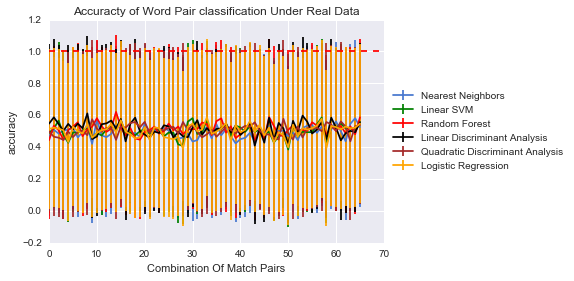

In [136]:
# Plotting accuracy
print accuracy.shape
plt.errorbar(np.arange(0,66), accuracy[:,0,0], yerr = accuracy[:,0,1], hold=True, label=names[0])
plt.errorbar(np.arange(0,66), accuracy[:,1,0], yerr = accuracy[:,1,1], color='green', hold=True, label=names[1])
plt.errorbar(np.arange(0,66), accuracy[:,2,0], yerr = accuracy[:,2,1], color='red', hold=True, label=names[2])
plt.errorbar(np.arange(0,66), accuracy[:,3,0], yerr = accuracy[:,3,1], color='black', hold=True, label=names[3])
plt.errorbar(np.arange(0,66), accuracy[:,4,0], yerr = accuracy[:,4,1], color='brown', hold=True, label=names[4])
plt.errorbar(np.arange(0,66), accuracy[:,5,0], yerr = accuracy[:,5,1], color='orange', hold=True, label=names[5])
# plt.xscale('log')
plt.xlabel('Combination Of Match Pairs')
plt.ylabel('accuracy')
plt.title('Accuracty of Word Pair classification Under Real Data')
plt.axhline(1, color='red', linestyle='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

We see here that all of our classifiers essentially performed as well as chance still... 